***
# EDA emotions_with_neutrals_220228.csv dataset
Concatenated the neutrals from Kaggle dataset with Huggingface dataset<br>
https://github.com/dair-ai/emotion_dataset<br>
https://huggingface.co/datasets/dair-ai/emotion
***

***
## 1 Load the train/test/val datasets
 <span style="color:red">!!!Make sure to comment out the correct source (Google drive or local)!!!</span>

In [115]:
import pandas as pd
import numpy as np
import random

# mount google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [211]:
# read from the google drive
project_folder = '/content/gdrive/MyDrive/266_Final_Project_Folder'

train_source = project_folder + '/datasets/train_data_imbalanced_stratified_no_dupe.csv'
test_source = project_folder + '/datasets/test_data_imbalanced_stratified_no_dupe.csv'
val_source = project_folder + '/datasets/validation_data_imbalanced_stratified_no_dupe.csv'
balanced_test_source = project_folder + '/datasets/test_data_balanced_no_dupe.csv'

# Load the dfs
train_df = pd.read_csv(train_source)
test_df = pd.read_csv(test_source)
val_df = pd.read_csv(val_source)
balanced_test_df = pd.read_csv(balanced_test_source)

In [212]:
# drop the tweet_id column
train_df.drop(columns=train_df.columns[0], axis=1, inplace=True)
test_df.drop(columns=test_df.columns[0], axis=1, inplace=True)
val_df.drop(columns=val_df.columns[0], axis=1, inplace=True)
balanced_test_df.drop(columns=balanced_test_df.columns[0], axis=1, inplace=True)

In [163]:
# Extract the 'text' column from both dataframes
train_texts = train_df['text']
val_texts = val_df['text']

# Check if there are any records in train_df that are in val_df
overlap = train_texts.isin(val_texts)

# Print the number of overlapping records
print(f"Number of overlapping records: {overlap.sum()}")

# Check if there are any records in train_df that are in val_df
overlap = val_texts.isin(train_texts)

# Print the number of overlapping records
print(f"Number of overlapping records: {overlap.sum()}")

Number of overlapping records: 0
Number of overlapping records: 0


In [119]:
train_df

,text,emotions
0,ive been feeling rather jealous,anger
1,ive officially started to feel uncomfortable,fear
2,im acting like the rotten person i am who feel...,sadness
3,i feel a mournful grasp,sadness
4,i started to feel smug,joy
...,...,...
256227,i don t get that one feeling anymore just curi...,surprise
256228,i was feeling a little unhappy in almost all a...,sadness
256229,i was there and soon to be berlin feeling gloo...,sadness
256230,im feeling a little too violent and my mother ...,anger


In [120]:
test_df

,text,emotions
0,i feel impatient to get moving forward,anger
1,i have decided to open wb to a few thoughtful ...,joy
2,i resolved at that moment to do my bit when i ...,sadness
3,i like his tip especially if you need assistan...,joy
4,i feel that if he did not want to be on the sh...,joy
...,...,...
37956,i am serving alongside other leaders in the de...,fear
37957,i am a little tipsy and feeling quite fond of ...,love
37958,i made my way to the front of the stage feelin...,fear
37959,i feel like nicholas is a really smart guy and...,joy


In [121]:
val_df

,text,emotions
0,im starting to feel a lot less terrified of her,fear
1,i can t appease everyone my lives are mainly i...,sadness
2,i feel for him is so valuable absolute and rar...,joy
3,i am friendly and so easy to talk to if only y...,fear
4,i came into the game feeling a bit lonely and ...,sadness
...,...,...
85406,i miss feeling insulted or feeling discouraged...,anger
85407,i feel like they liked my rough draft,love
85408,i just need to adjust my mindset to feel pleas...,joy
85409,id be working a max of hours if theyre feeling...,joy


***
## 2 Tokenizer

### Find the top word count (frequency > 10)

In [122]:
# Split the text column into a list of words
words_df = train_df['text'].str.split().to_frame('words')

# Explode the list of words into separate rows
words_df = words_df.explode('words')

# Group by the words and count their occurrences
words_df = words_df.groupby('words').size().reset_index(name='count')
words_df

,words,count
0,!,43
1,!!,9
2,!!!,3
3,!!!!,1
4,!!!!!!!!!!!!,1
...,...,...
73765,ï¿½o_0ï¿½*giggles*ï¿½who,1
73766,ï¿½tearï¿½,1
73767,ï¿½ureo,1
73768,ï¿½why?,1


In [123]:
# find the words with 'count' > 10
condition = words_df['count'] > 10

# sort the words based on count
new_words_df = words_df[condition].sort_values('count', ascending=False)

new_words_df

,words,count
35522,i,406035
28222,feel,173555
10149,and,150667
66570,to,140963
65637,the,131883
...,...,...
66925,tore,11
24444,doula,11
11821,autonomy,11
48630,operations,11


In [124]:
# how many words are > 10?
top_word_count = len(new_words_df) # 10,179 words are greater than 10 count

### Let's tokenize the train tweets!

In [125]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [126]:
tokenizer = Tokenizer(num_words=top_word_count, oov_token='<UNK>')
tokenizer.fit_on_texts(train_df['text']) # pass in tweets from training set

In [127]:
# this is what the tweet looks like as words
train_df['text'][0]

'ive been feeling rather jealous'

In [128]:
# this is what the tokenized version of the tweet looks like
tokenizer.texts_to_sequences([train_df['text'][0]])

[[74, 47, 8, 194, 427]]

(array([2.7100e+02, 8.3600e+02, 4.9050e+03, 1.7587e+04, 1.0099e+04,
        9.9730e+03, 1.0327e+04, 2.0549e+04, 1.0492e+04, 1.0265e+04,
        1.0004e+04, 1.9662e+04, 9.2690e+03, 9.1240e+03, 8.4760e+03,
        1.5868e+04, 7.4850e+03, 6.7480e+03, 1.2427e+04, 5.6720e+03,
        5.1510e+03, 4.7190e+03, 8.3660e+03, 3.5790e+03, 3.2520e+03,
        3.0450e+03, 5.3200e+03, 2.3020e+03, 2.0350e+03, 1.8770e+03,
        3.2480e+03, 1.4790e+03, 1.3510e+03, 2.2750e+03, 9.8900e+02,
        9.3000e+02, 8.1000e+02, 1.3820e+03, 5.7900e+02, 5.5500e+02,
        5.3000e+02, 8.3000e+02, 3.5300e+02, 3.0100e+02, 2.3900e+02,
        3.1500e+02, 1.0900e+02, 8.1000e+01, 1.0200e+02, 2.8000e+01,
        1.8000e+01, 1.4000e+01, 1.2000e+01, 5.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

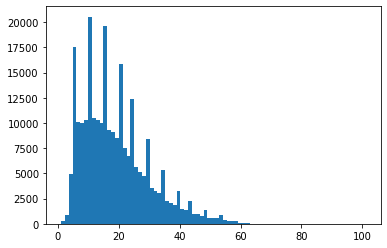

In [129]:
import matplotlib.pyplot as plt

# check to see what lenghts of the tweets in the dataset
lengths = [len(t.split(' ')) for t in train_df['text']]
plt.hist(lengths, bins=len(set(lengths)))

In [164]:
import statistics

# Apply the lambda function to the 'content' column and list called word_count_list'
word_count_list = list(train_df['text'].apply(lambda x: len(x.split(' '))))

# display the maximum and minimum lengths
print('Maximum word count:', max(word_count_list))
print('Minimum word count:', min(word_count_list))
print('Mean word count:', statistics.mean(word_count_list))
print('Median word count:', statistics.median(word_count_list))
print('75th percentile word count:', np.percentile(word_count_list, 75))
print('85th percentile word count:', np.percentile(word_count_list, 85))
print('95th percentile word count:', np.percentile(word_count_list, 95))

Maximum word count: 101
Minimum word count: 1
Mean word count: 18.995761653501514
Median word count: 17.0
75th percentile word count: 25.0
85th percentile word count: 30.0
95th percentile word count: 41.0


The max number of words is 178. We ultimately decided that we are going to keep all the words in the tweet. BERT can handle more than 200 so setting max_len = 200

## 3 Padding and truncating the sequences to make sure that the shape is the same for each string.

In [131]:
max_len = 200 # set the largest tweet size, >200 words -- truncate, <200 words -- pad

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [132]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len) # truncating happens at the end of the sequence (post)
  return padded # all examples will be the returned with same input size

In [133]:
padded_train_seq = get_sequences(tokenizer, train_df['text'])
padded_train_seq[0]

array([ 74,  47,   8, 194, 427,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## 4 Convert labels to numeric

### Function to convert text labels to numeric (reuse for train, test, val)

In [134]:
def convert_labels_to_numeric(data):
  classes = set(data)

  # convert class to index
  c_to_i = dict((c, i) for i, c in enumerate(classes))
  i_to_c = dict((v, k) for k, v in c_to_i.items())
  
  return c_to_i

In [135]:
class_to_index_train = convert_labels_to_numeric(train_df['emotions'])
class_to_index_train

{'joy': 0,
 'surprise': 1,
 'neutral': 2,
 'fear': 3,
 'anger': 4,
 'sadness': 5,
 'love': 6}

In [136]:
def names_to_ids(class_to_index, data):
  return np.array([class_to_index.get(x) for x in data])

In [137]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
train_labels = names_to_ids(class_to_index_train, train_df['emotions'])
print('train_df.iloc[7]:\n', train_df.iloc[index])
print('numeric label:', train_labels[index])

train_df.iloc[7]:
 text        i do think that with a heartfelt discussion my...
emotions                                                 fear
Name: 7, dtype: object
numeric label: 3


## 5 Create the model

In [138]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.11.0


In [139]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10179, output_dim=8, input_length=max_len),
    
    # the RNN part of the model
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)), # since using an LSTM layer inside a bidrectional layer, context can go in either direction; return_sequences=True means at every time step, there is an output
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, )),

    tf.keras.layers.Dense(7, activation='softmax') # 7 for the six classes

])

model.compile(
    loss='sparse_categorical_crossentropy', # since this is a multiclass classification problem, use categorical crossentropy; since classes are integers (not one hot encoded/binary), use sparse (just like in A3)
    optimizer='adam',
    metrics=['accuracy']
)

In [140]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 8)            81432     
                                                                 
 bidirectional_2 (Bidirectio  (None, 20)               1520      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 7)                 147       
                                                                 
Total params: 83,099
Trainable params: 83,099
Non-trainable params: 0
_________________________________________________________________


## 6 Train the model

### Convert the labels of the validation set to numeric (just like the training set)

In [141]:
class_to_index_val = convert_labels_to_numeric(val_df['emotions'])
class_to_index_val

{'joy': 0,
 'surprise': 1,
 'neutral': 2,
 'fear': 3,
 'anger': 4,
 'sadness': 5,
 'love': 6}

In [142]:
val_seq = get_sequences(tokenizer, val_df['text'])
val_labels = names_to_ids(class_to_index_val, val_df['emotions'])

In [143]:
val_seq[0], val_df['text'][0], val_df['emotions'][0]

(array([ 17, 306,   5,   3,   7, 160, 170, 486,  10,  68,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [144]:
print('val_df.iloc[0]:\n', val_df.iloc[0])
print('numeric label:', val_labels[0])

val_df.iloc[0]:
 text        im starting to feel a lot less terrified of her
emotions                                               fear
Name: 0, dtype: object
numeric label: 3


#### Check out the shape to make sure they're as expected

In [145]:
padded_train_seq.shape

(256232, 200)

In [146]:
train_labels.shape

(256232,)

In [147]:
val_seq.shape

(85411, 200)

In [148]:
val_labels.shape

(85411,)

### From Natalie's Notebook
https://github.com/datasci-w266/2023-spring-main/blob/master/materials/walkthrough_notebooks/keras_with_limited_ram/keras_training_with_limited_ram.ipynb<br><br>
https://edstem.org/us/courses/32607/discussion/2699088?comment=6229916

#### Inspired by Natalie's notebook, made my own generator that chunks up my data into pieces that won't make my machine run out of memory before completing one epoch

In [149]:
# Define a generator function
def generator(data, labels, batch_size):
    num_samples = len(data)
    while True:
        indices = np.random.randint(num_samples, size=batch_size)
        yield data[indices], labels[indices]

In [150]:
# Create the generator
batch_size = 6 # using batch size 6 because that's what seemed reasonable based on the number of records in the training dataset
gen = generator(data=padded_train_seq, labels=train_labels, batch_size=batch_size)

In [151]:
!ls '/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/'

archive		      weights.02-0.98.hdf5  weights.04-0.99.hdf5
weights.01-0.97.hdf5  weights.03-0.98.hdf5  weights.05-0.99.hdf5


In [152]:
checkpoint_dir = project_folder + '/cm_working_dir/cm_checkpoints'
checkpoint_filepath = checkpoint_dir + '/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [153]:
print(checkpoint_filepath)

/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5


### Training the Model!!!

In [154]:
# uncomment below when loading checkpoints
# hdf5_checkpoint = '/weights.05-0.75.hdf5' # change this to the right filename for the checkpoint
# checkpoint_filepath = checkpoint_dir + hdf5_checkpoint
# model.load_weights(checkpoint_filepath)

In [155]:
steps_per_epoch = len(padded_train_seq) // batch_size

history = model.fit(
    gen,
    validation_data=(val_seq, val_labels),
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
        model_checkpoint_callback
    ]
)

Epoch 1/5
42705/42705 [==============================] - 671s 16ms/step - loss: 0.2393 - accuracy: 0.9206 - val_loss: 0.0825 - val_accuracy: 0.9737
Epoch 2/5
42705/42705 [==============================] - 649s 15ms/step - loss: 0.0551 - accuracy: 0.9826 - val_loss: 0.0526 - val_accuracy: 0.9832
Epoch 3/5
42705/42705 [==============================] - 653s 15ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.0458 - val_accuracy: 0.9855
Epoch 4/5
42705/42705 [==============================] - 654s 15ms/step - loss: 0.0301 - accuracy: 0.9905 - val_loss: 0.0414 - val_accuracy: 0.9874
Epoch 5/5
42705/42705 [==============================] - 694s 16ms/step - loss: 0.0247 - accuracy: 0.9924 - val_loss: 0.0419 - val_accuracy: 0.9878


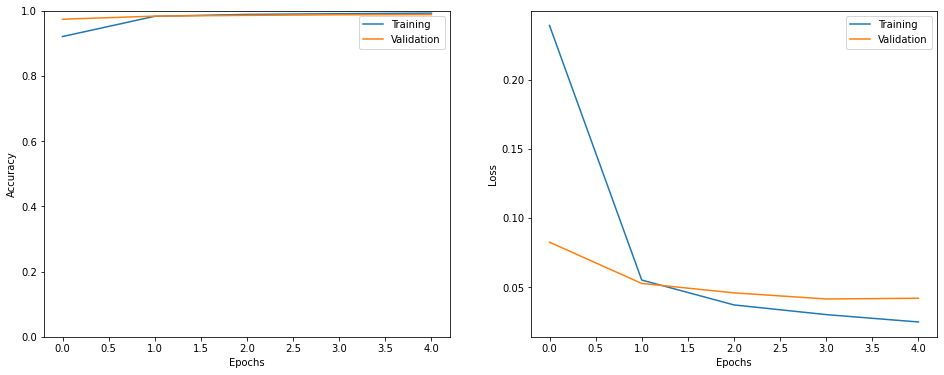

In [156]:
show_history(history)

## 7 Evaluate the model using test_df

In [221]:
padded_test_seq = get_sequences(tokenizer, test_df['text'])
padded_test_seq[0]

array([  2,   3, 537,   5,  54, 885, 754,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [222]:
padded_balanced_test_seq = get_sequences(tokenizer, balanced_test_df['text'])
padded_balanced_test_seq[0]

array([   2,   57,   54,   33,    6,  233,   10,    6,  507,    9,   31,
        114,   31,   69,   25,    4,    3,   60,    6,  233,    9, 1084,
         31,   36,  141,  731,    6, 2215,   10,  121, 7038,   10,  107,
         31,  796, 1263,   19,    7, 1046,  881,    1, 2250,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [223]:
# converting the text labels to a numeric value
class_to_index_test = convert_labels_to_numeric(test_df['emotions'])
class_to_index_test

{'joy': 0,
 'surprise': 1,
 'neutral': 2,
 'fear': 3,
 'anger': 4,
 'sadness': 5,
 'love': 6}

In [224]:
# converting the text labels to a numeric value
class_to_index_balanced_test = convert_labels_to_numeric(balanced_test_df['emotions'])
class_to_index_balanced_test

{'joy': 0,
 'surprise': 1,
 'neutral': 2,
 'fear': 3,
 'anger': 4,
 'sadness': 5,
 'love': 6}

In [225]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
test_labels = names_to_ids(class_to_index_test, test_df['emotions'])
print('test_df.iloc[7]:\n', test_df.iloc[index])
print('numeric label:', test_labels[index])

test_df.iloc[7]:
 text        i never orgasm the feeling is lovely
emotions                                    love
Name: 7, dtype: object
numeric label: 6


In [226]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
balanced_test_labels = names_to_ids(class_to_index_test, balanced_test_df['emotions'])
print('balanced_test_df.iloc[7]:\n', balanced_test_df.iloc[index])
print('numeric label:', balanced_test_labels[index])

balanced_test_df.iloc[7]:
 text        i feel like i m wronged
emotions                      anger
Name: 7, dtype: object
numeric label: 4


### Evaluating the model for test_df!!!

In [227]:
model.evaluate(padded_test_seq, test_labels)

1187/1187 [==============================] - 10s 8ms/step - loss: 0.0401 - accuracy: 0.9875


[0.04009264335036278, 0.9875134825706482]

In [228]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_df.iloc[i])
print('Emotion:', test_labels[i])

p = model.predict(np.expand_dims(padded_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        i hate this feeling i hate feeling ugly
emotions                                    sadness
Name: 11712, dtype: object
Emotion: 5
1/1 [==============================] - 0s 38ms/step
Predicted Emotion: 5


In [229]:
preds = model.predict(padded_test_seq)

1187/1187 [==============================] - 9s 7ms/step


In [230]:
# classification report from A3
from sklearn.metrics import classification_report

predictions_model1 = tf.argmax(preds, axis=-1)
predictions_model1

target_names = list(set([str(digit) for digit in test_labels]))

print(classification_report(test_labels, predictions_model1.numpy(), target_names=target_names))

              precision    recall  f1-score   support

           3       0.99      0.99      0.99     12917
           0       0.95      0.99      0.97       982
           6       0.96      0.96      0.96       860
           5       0.98      0.98      0.98      3955
           1       0.98      0.98      0.98      5226
           2       0.99      0.99      0.99     11587
           4       0.99      0.99      0.99      2434

    accuracy                           0.99     37961
   macro avg       0.98      0.98      0.98     37961
weighted avg       0.99      0.99      0.99     37961



Text(159.0, 0.5, 'True')

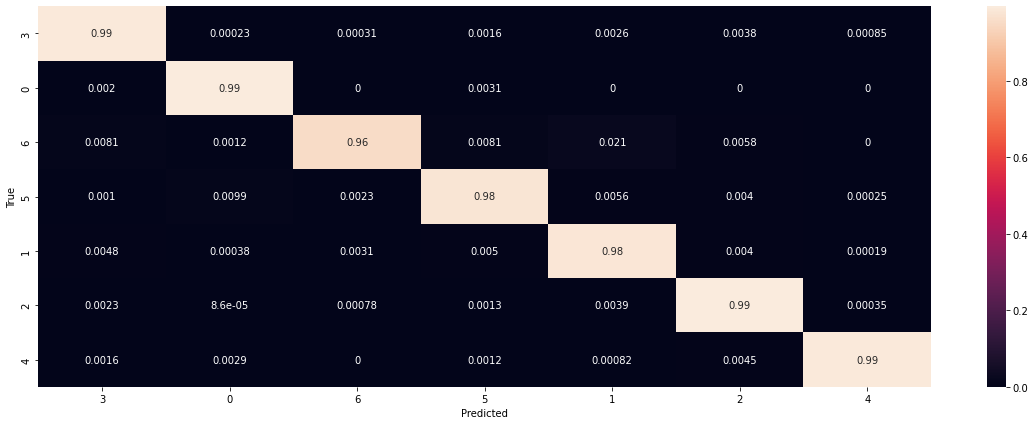

In [231]:
import seaborn as sns

# confusion matrix from A3
cm = tf.math.confusion_matrix(test_labels, predictions_model1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

### Evaluating again, but with balanced_test_df!!!

In [232]:
model.evaluate(padded_balanced_test_seq, balanced_test_labels)

189/189 [==============================] - 1s 7ms/step - loss: 0.0587 - accuracy: 0.9834


[0.058711688965559006, 0.9833887219429016]

In [233]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(balanced_test_labels) - 1)

print('Sentence:', balanced_test_df.iloc[i])
print('Emotion:', balanced_test_labels[i])

p = model.predict(np.expand_dims(padded_balanced_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        im feeling a bit messy
emotions                   sadness
Name: 4824, dtype: object
Emotion: 5
1/1 [==============================] - 0s 29ms/step
Predicted Emotion: 5


In [234]:
preds2 = model.predict(padded_balanced_test_seq)

189/189 [==============================] - 1s 7ms/step


In [235]:
# classification report from A3

predictions_model2 = tf.argmax(preds2, axis=-1)
predictions_model2

target_names2 = list(set([str(digit) for digit in balanced_test_labels]))

print(classification_report(balanced_test_labels, predictions_model2.numpy(), target_names=target_names2))

              precision    recall  f1-score   support

           3       0.98      0.99      0.99       860
           0       0.99      0.99      0.99       860
           6       1.00      0.96      0.98       860
           2       0.98      0.98      0.98       860
           5       0.97      0.98      0.98       860
           1       0.97      0.99      0.98       860
           4       1.00      0.99      0.99       860

    accuracy                           0.98      6020
   macro avg       0.98      0.98      0.98      6020
weighted avg       0.98      0.98      0.98      6020



Text(159.0, 0.5, 'True')

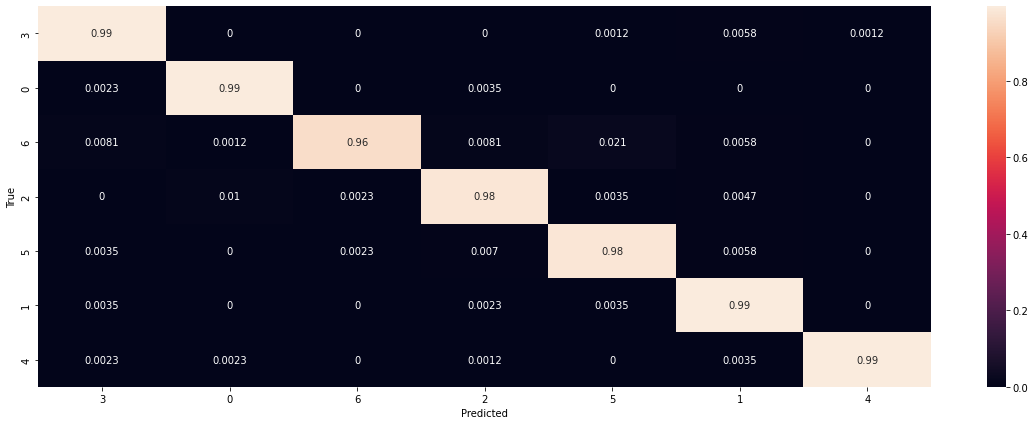

In [236]:
# confusion matrix from A3
cm = tf.math.confusion_matrix(balanced_test_labels, predictions_model2)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names2,
    yticklabels=target_names2)
plt.xlabel("Predicted")
plt.ylabel("True")